In [3]:
import torch
from src.k_tree import Ktree
from src.utils.data import loadData_3d
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data, _ = loadData_3d(1000, 100)
x_lim = [data[:,0].min(), data[:,0].max()]
y_lim = [data[:,1].min(), data[:,1].max()]
z_lim = [data[:,2].min(), data[:,2].max()]
#data = np.load('./data_3d/10000cb/100cb_1_4.npy')

learning_rate = 2e-2 # 1e-2, 5e-3
k = 3
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 300, # 200
    "times": 10,
    "alpha": 20, # 5
    "beta": 10,
    "number_of_centroids": k
}
n = 20
un_args = {
    "N": n,# 30,20
    "M": n**3-1, # 10000 - 1
    "epsilon": 0.14 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3, #2e-2
    "epochs": 2000, # 30000
    "width": 200, # 100
    "depth": 5, # 3
}

# threshold = 0.1 * len(data) if len(data) > 500 else 30*len(data)
stop_criterion = 0.3*len(data) if len(data) > 500 else 100
threshold = stop_criterion
print("threshold: ", threshold)
#threshold = 30
ktree = Ktree(threshold, data, teacher_args, un_args, student_args, 3)
print("="*20)
print("Start training")
print("="*20)
ktree.create_tree(save_path_prefix="models/cuboids/1000/class")

Loading data...
Data loaded.
threshold:  300.0
Start training

Creating student for node 0 that has 1000 data, which is more than the threshold 300.0.
Bounding box for node 0: [[42, 956], [42, 957], [42, 957]]
Creating teacher for node 0 with 3 centroids.
Training Teacher Model
Epoch: 30/300..  Training loss: 493724.34375..  Reg Proj: 0.00000..  Reg Latent: 555.48615..  Repulsive: 3.10605..  Memory: 488167.90625..  Cost: 493724.34375.. 
Epoch: 60/300..  Training loss: 58410252.00000..  Reg Proj: 288.80615..  Reg Latent: 518.40393..  Repulsive: 2.34670..  Memory: 643836.87500..  Cost: 58410252.00000.. 
Epoch: 90/300..  Training loss: 623704.00000..  Reg Proj: 0.00000..  Reg Latent: 837.31348..  Repulsive: 1.99075..  Memory: 615329.87500..  Cost: 623704.00000.. 
Epoch: 120/300..  Training loss: 546010.25000..  Reg Proj: 0.00000..  Reg Latent: 1138.81165..  Repulsive: 1.76431..  Memory: 534621.25000..  Cost: 546010.25000.. 
Epoch: 150/300..  Training loss: 519694.87500..  Reg Proj: 0.0000

## Debug UN 3d

(17, 9)
(156, 9)
(827, 9)
f shape: torch.Size([2123])
label shape: torch.Size([2123])
points shape: (2123, 3)
min_z: 42.0
max_z: 812.5263061523438


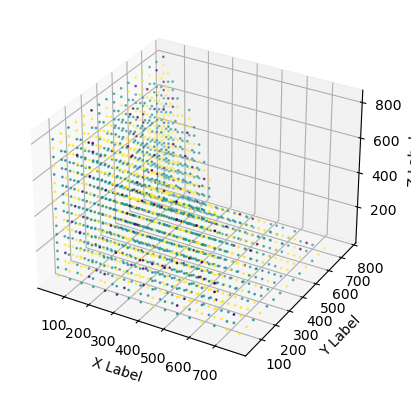

In [4]:
root = ktree.root
children = root.children
# print all children data shapes
for child in children:
    print(child.data.shape)

labels = root.un_labels
e = root.un_energy
points = root.un_points
f, label = e.min(1)
print(f'f shape: {f.shape}')
print(f'label shape: {label.shape}')
print(f'points shape: {points.shape}')

z_ax = points[:,2]
# get max and min of z_ax
min_z = z_ax.min()
max_z = z_ax.max()
# print
print(f'min_z: {min_z}')
print(f'max_z: {max_z}')

# plot points with label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=label,s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.view_init(azim=0, elev=90)

plt.show()

In [7]:
times = 0
end = 10
mean_acc = 0
best_acc = 0
wost_acc = 100
wanna_plot = False
while times < end:
    times+=1
    # random n querry points
    n =  100   
    random_p = torch.zeros(n, 3)
    for i in range(n):
        x = np.random.uniform(x_lim[0],x_lim[1])
        y = np.random.uniform(y_lim[0],y_lim[1])
        z = np.random.uniform(z_lim[0],z_lim[1])
        random_p[i] = torch.Tensor([x, y, z])
    infer_points = random_p.to(device)
    if wanna_plot:
        # plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(random_p[:,0], random_p[:,1], random_p[:,2], c='royalblue',s=1)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        #ax.view_init(azim=0, elev=90)
        plt.show()
    num_of_correct_predictions = 0
    wanna_print = False 
    for query_point in infer_points:
        pred = ktree.query(query_point)
        brute_force = ktree.root.query(query_point)
        if np.array_equal(pred, brute_force):
            num_of_correct_predictions += 1
        else:
            if wanna_print:
                print(f'Query: {query_point}')
                print(f'Brute force prediction: {brute_force}')
                print(f'Prediction from student model: {pred}')
                print()
    acc = (num_of_correct_predictions / len(infer_points)) * 100
    print(f"The percentage of correct predictions is {acc}%")
    if acc > best_acc:
        best_acc = acc
    if acc < wost_acc:
        wost_acc = acc
    mean_acc += acc

print(f"Worst acc: {wost_acc}")
print(f"Mean acc: {mean_acc/end}")
print(f"Best acc: {best_acc}")

The percentage of correct predictions is 84.0%
The percentage of correct predictions is 88.0%
The percentage of correct predictions is 85.0%
The percentage of correct predictions is 83.0%
The percentage of correct predictions is 82.0%
The percentage of correct predictions is 82.0%
The percentage of correct predictions is 81.0%
The percentage of correct predictions is 84.0%
The percentage of correct predictions is 87.0%
The percentage of correct predictions is 78.0%
Worst acc: 78.0
Mean acc: 83.4
Best acc: 88.0


added: 1000


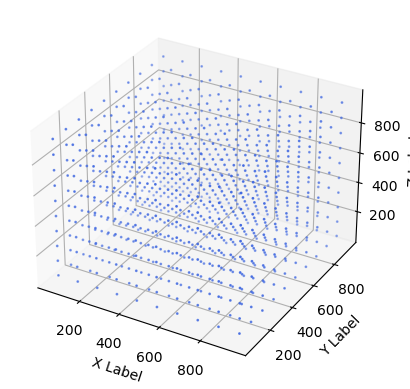

In [11]:
# also get points
base = 10
nop = base**3    # 512 points.
random_p = torch.zeros(nop, 3)
x_lim = [50,950]
y_lim = [50,950]
z_lim = [50,950]
added = 0
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], base)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], base)):
        for k, z in enumerate(np.linspace(z_lim[0],z_lim[1], base)):
            index = i * (base ** 2) + j * base + k
            random_p[index] = torch.Tensor([x, y, z])
            added +=1
print(f'added: {added}')
 
infer_points = random_p.to(device)
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(infer_points[:,0], infer_points[:,1], infer_points[:,2], c='royalblue',s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.view_init(azim=0, elev=90)
plt.show()

In [9]:
num_of_correct_predictions = 0
wanna_print = False 
for query_point in infer_points:
    pred = ktree.query(query_point)
    brute_force = ktree.root.query(query_point)
    if np.array_equal(pred, brute_force):
        num_of_correct_predictions += 1
    else:
        if wanna_print:
            print(f'Query: {query_point}')
            print(f'Brute force prediction: {brute_force}')
            print(f'Prediction from student model: {pred}')
            print()
print(f"The percentage of correct predictions is {(num_of_correct_predictions / len(infer_points)) * 100:.2f}%")

The percentage of correct predictions is 89.60%


torch.Size([1000])


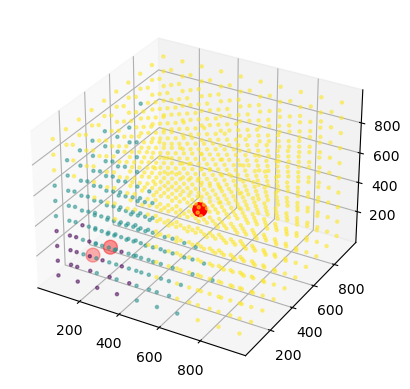

In [12]:
pred_z = ktree.root.student(infer_points).argmax(1)
print(pred_z.shape)
# plot with pred_z label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(infer_points[:,0], infer_points[:,1], infer_points[:,2], c=pred_z,s=5,alpha=0.5)
# =======
res = np.load('./models/cuboids/1000/class0_teacher_training_results.npy', allow_pickle=True).item()
centroids = res['best_outputs'].detach().cpu().numpy()
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='r', marker='o', s=100)

plt.show()

In [ ]:
c = np.load('./models/cuboids/1000/class03_teacher_training_results.npy', allow_pickle=True).item()['best_outputs'].detach().cpu().numpy()
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c[:,0], c[:,1], c[:,2], c='r', marker='o', s=100)
plt.show()


## Inference

In [ ]:
# Print a student prediction both using the student model from training
# and the student model loaded from config. The two outputs should be equal.
query = torch.tensor([[4., 2., 0.], [2., 0., -2.]]).to(device)

pred_trained = ktree.root.student(query)
print(pred_trained)

# Recreate the student model from config.
node = Ktree.Node(ktree.root.data, "", ktree, None)
node.create_student_from_config("models/cuboids/1000/class0_student_config.pt")
pred_config = node.student(query)
print(pred_config)

print("Predictions are " + "equal." if torch.equal(pred_trained, pred_config) else "NOT equal.")